In [1]:
import tensorflow as tf
import pandas as pd

import os
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from matplotlib.ticker import FixedLocator, FixedFormatter, FuncFormatter, MultipleLocator

from src.ForecastModel.utils.postprocessing import ModelHandler

import numpy as np
import pandas as pd

plt.rcParams.update({
    "text.usetex": False,
    'font.size'   : 8,
})

In [2]:
def get_scalar_from_tb(tag, path):
    values, steps = [], []
    for e in tf.compat.v1.train.summary_iterator(path):
        if len(e.summary.value) > 0: 
            if e.summary.value[0].tag == tag:
                tensor = e.summary.value[0].tensor
                step   = e.step
                value  = tf.io.decode_raw(tensor.tensor_content, tf.float32)[0].numpy()
                values.append(value)
                steps.append(step)
    return values, steps


In [3]:
PLOT_PATH = r"plots"

In [4]:
models = {
     "pbhm-hlstm": ModelHandler("PBHM-HLSTM",
                   r"rst\PBHM-HLSTM",
                   is_final_model = True,
                   color = "#56B4E9",
                   ls = "-",
                 ),
     "elstm": ModelHandler("eLSTM",
                   r"rst\eLSTM",
                   is_final_model = True,
                   color = "#D55E00",
                   ls = "-",
                 ),
     }


In [5]:
df = pd.DataFrame(index = np.arange(100))
for key in models.keys():
    for n_fold in range(5):

        # get validation data
        path = os.path.join(models[key].lg_path, "tb", f"fold_{n_fold:02d}", "validation")
        for file in os.listdir(path):
            if file.split(".")[-1] == "v2":
                epoch_loss, step = get_scalar_from_tb("epoch_loss", os.path.join(path, file))
                df.loc[np.arange(len(epoch_loss)), f"valid_{key}_{n_fold}"] = epoch_loss

        # get training and retraining data
        path = os.path.join(models[key].lg_path, "tb", f"fold_{n_fold:02d}", "train")
        time_of_creation = []
        epoch_losses     = []
        
        for file in os.listdir(path):
            # newer file is retraining
            if file.split(".")[-1] == "v2":
                epoch_loss, step = get_scalar_from_tb("epoch_loss", os.path.join(path, file))
                epoch_losses.append(epoch_loss)
                time_of_creation.append(os.path.getmtime(os.path.join(path, file)))

        if len(epoch_losses) != 2:
            raise ValueError("wrong number of files encountered")

        first_idx  = np.argmin(time_of_creation)
        second_idx = np.argmax(time_of_creation)

        df.loc[np.arange(len(epoch_losses[first_idx])), f"train_{key}_{n_fold}"]   = epoch_losses[first_idx]
        df.loc[np.arange(len(epoch_losses[second_idx])),f"retrain_{key}_{n_fold}"] = epoch_losses[second_idx]


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


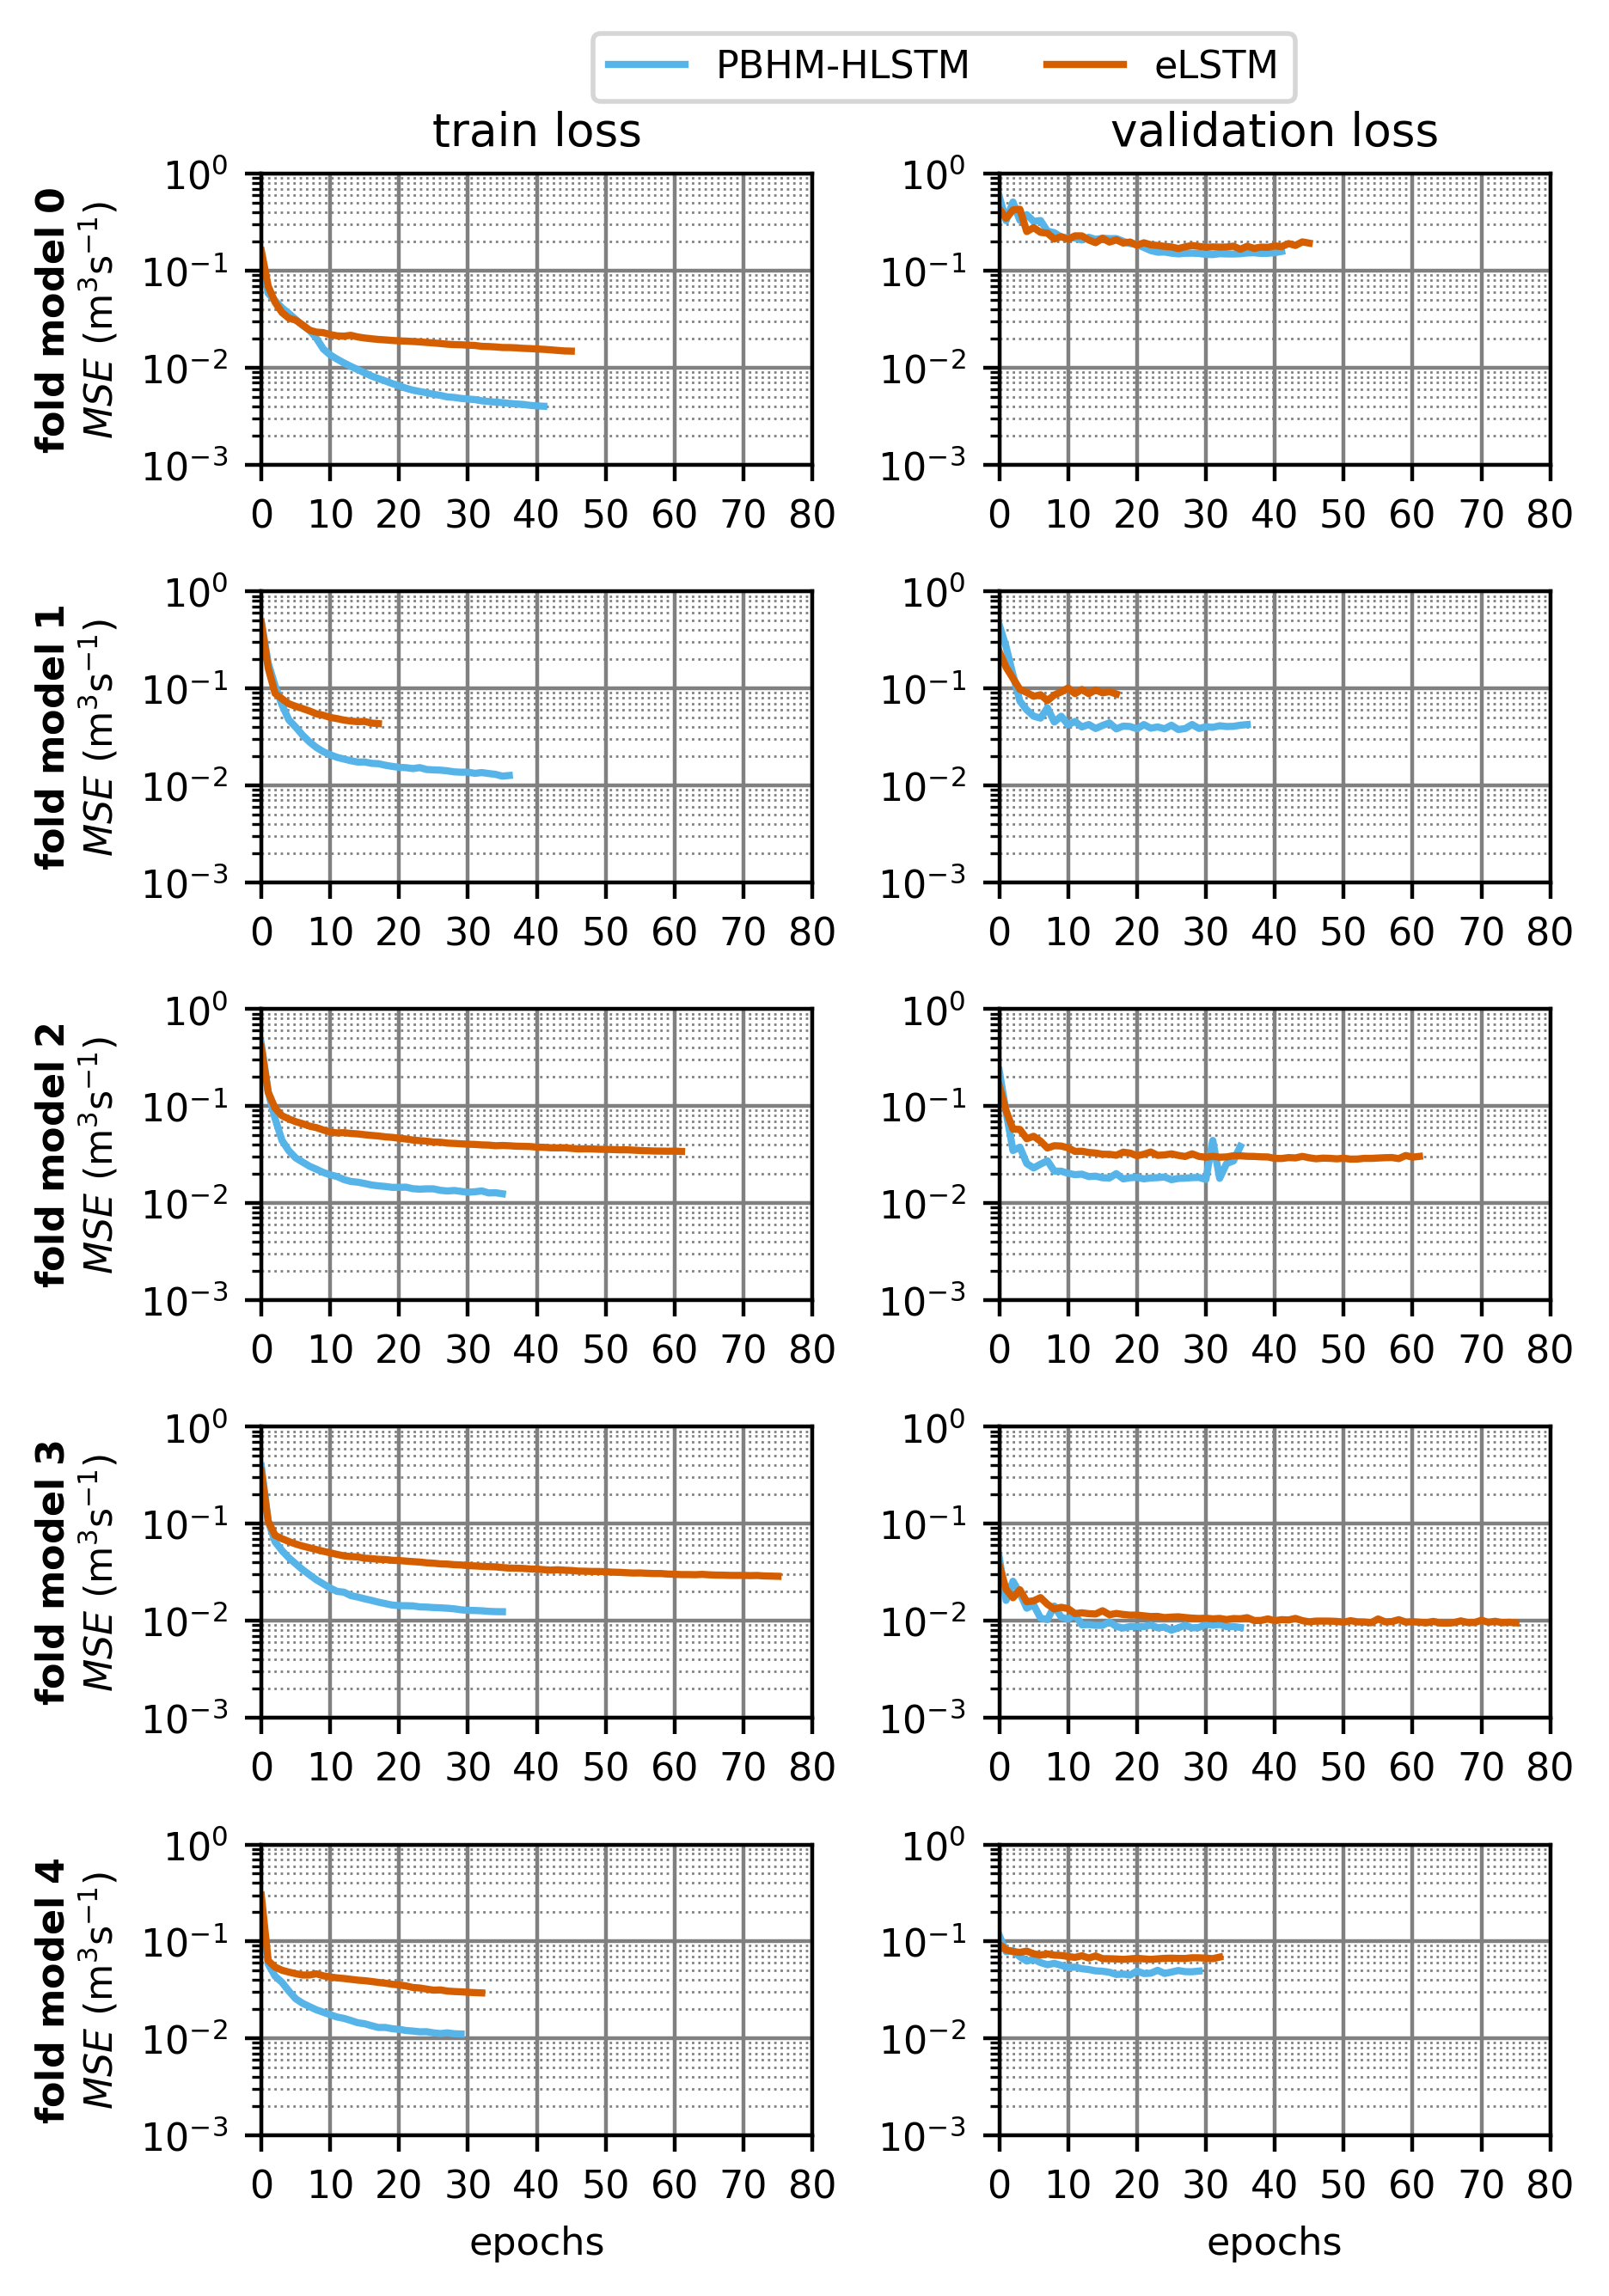

In [6]:
fig, axes = plt.subplots(5,2,figsize=(4.72,6.5), dpi=400)

dftrain= df.filter(regex="^train_")
dfvalid = df.filter(like="valid")


axes[0,0].set_title("train loss")
axes[0,1].set_title("validation loss")


for n_fold in range(5):
    axes[n_fold,0].set_ylabel(r"$\bf{fold\ model\ "+f"{n_fold}"+r"}$" + "\n" + r"$MSE\ (\text{m}^3\text{s}^{-1})$")
    if n_fold == 4:
        axes[n_fold,0].set_xlabel("epochs")
        axes[n_fold,1].set_xlabel("epochs")
        
    dfb = dftrain.filter(regex=f"_{n_fold}")
    for col in dfb.columns:
        key = col.split("_")[1]
        axes[n_fold,0].plot(dfb[col], label=models[key].name, color=models[key].color, lw=1.5)

    dfb = dfvalid.filter(regex=f"_{n_fold}")
    for col in dfb.columns:
        key = col.split("_")[1]
        axes[n_fold,1].plot(dfb[col], label=models[key].name, color=models[key].color, lw=1.5)

    for n in range(2):
        axes[n_fold, n].xaxis.set_major_locator(MultipleLocator(10))
        axes[n_fold, n].grid(which='major', color='grey', linestyle='-')
        axes[n_fold, n].grid(which='minor', color='grey', linestyle=':', lw=0.5)
        axes[n_fold, n].set_xlim(0,80)
        axes[n_fold, n].set_ylim(0.001,1)
        axes[n_fold, n].set_yscale("log")

fig.tight_layout()
axes[0,1].legend(bbox_to_anchor=(-0.1, 1.25), 
                 loc='lower center', ncol=3, 
                 borderaxespad=0)

In [7]:
# save figure
fig.savefig(os.path.join(PLOT_PATH, 'figX_model_losses.png'), bbox_inches="tight", dpi=300)